In [32]:
from keras.models import load_model
import cv2
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import imageio
import h5py
import matplotlib.pyplot as plt
from PIL import Image
from scipy.misc import bytescale
import os, glob
import scipy.misc
import scipy.ndimage
import pandas as pd
import copy
import sys
import cv2
from scipy.misc import imresize

# Load trained CNN model 

In [41]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss
weights = np.array([.5,2,4]) # Class 1 at .5, class 2 four times the normal weights, class 3 8 times
loss = weighted_categorical_crossentropy(weights)

In [ ]:
# load model
model = load_model('model1.h5')

# Morphological processing

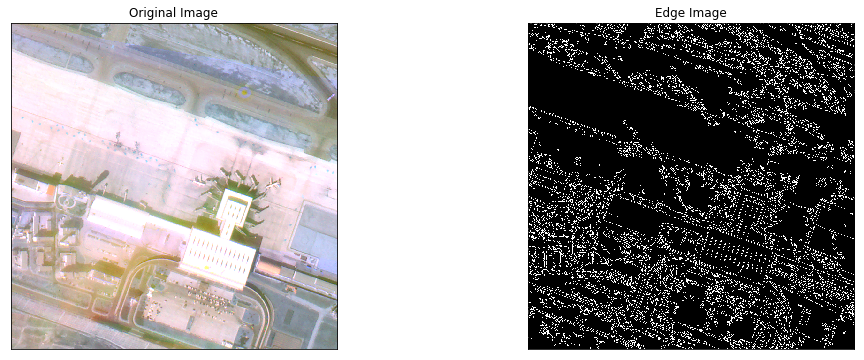

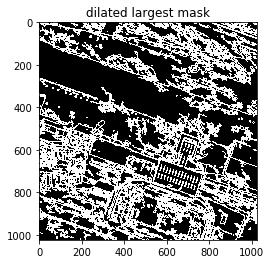

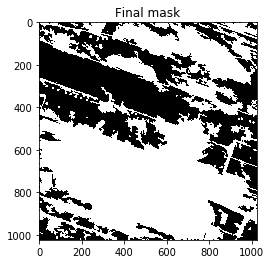

[[0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [112]:
def get_mask(img, plot=False):
    # get canny edges
    edges = cv2.Canny(img,0,200)
    if plot:
        
#     print(edges)
        plt.figure(figsize=(17,6))
        plt.subplot(121),plt.imshow(img,cmap = 'gray')
        plt.title('Original Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(edges,cmap = 'gray')
        plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    # dilating the edges
    iterations = 1 # experiment with this number!
    dilated_edges = scipy.ndimage.morphology.binary_dilation(edges,
                                                            iterations=iterations*2)
    if plot:
        plt.imshow(dilated_edges, cmap="gray")
        plt.title('dilated largest mask')
        plt.show()
        
    # fill hole
    img_mask = scipy.ndimage.morphology.binary_fill_holes(dilated_edges).astype(int)
    
    if plot:
        plt.imshow(img_mask, cmap="gray")
        plt.title('Final mask')
        plt.show()
    return img_mask
    

img = cv2.imread('../airport_crop/30.png')        
mask = get_mask(img, plot=True)
print(mask)

# Get proposals 

Code adapted from [here](https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/)

Total Number of Region Proposals: 4706
Plotting the first 200 region proposals with mode f


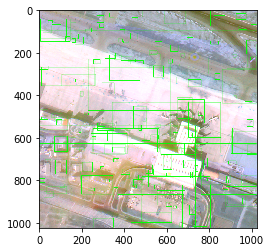

In [113]:
def get_proposals(img, selective_search_method='f', verbose=False, plot=False):
    """
    Inputs:
    - img_file: e.g., '30.png'
    - selective_search_method: 'f' (fast), or 'q' ('quality')
    - verbose: boolean
    
    Outputs:
    - rects: numpy array. rects[i] gives the information for the i-th proposal
    including x, y, w, h (x and y is the coordinate of the top left corner, w and
    h is the width and height of the box). 
    """
    
    # speed-up using multithreads
    cv2.setUseOptimized(True);
    cv2.setNumThreads(4);

    im = img

    # create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # set input image on which we will run segmentation
    ss.setBaseImage(im)

    # Switch to fast but low recall Selective Search method
    if (selective_search_method == 'f'):
        ss.switchToSelectiveSearchFast()

    # Switch to high recall but slow Selective Search method
    elif (selective_search_method == 'q'):
        ss.switchToSelectiveSearchQuality()

    # run selective search segmentation on input image
    rects = ss.process()
    if verbose:
        print('Total Number of Region Proposals: {}'.format(len(rects)))
    
    if plot:
        print(f'Plotting the first 200 region proposals with mode {selective_search_method}')
        imOut = im.copy()
        for i, rect in enumerate(rects):
            # draw rectangle for region proposal till numShowRects
            if (i < 200):
                x, y, w, h = rect
                
                cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            else:
                break
        plt.imshow(imOut)
        plt.show()
    return rects
rects = get_proposals(img=img, selective_search_method='f', verbose=True, plot=True)

# Reduce the number of proposals 

In [114]:
# Using the filtering mask be got above, eliminate propsals that have
# more than 10% of area outside the mask
def reduce_proposals(rects, mask, verbose=False):
    """
    Inputs:
    - rects: output from get_proposals
    - mask: output from get_mask
    """
    small_rects = []
    for i, rect in enumerate(rects):
        x,y,w,h = rect
        box = mask[y:y+h, x:x+w]
        box_area = w*h
        overlap_area = np.sum(box)
        if overlap_area/box_area >= .9:
            small_rects.append(rect)
    if verbose:
        print(f'Reduce from {rects.shape[0]} to {len(small_rects)}')
    return np.array(small_rects)
rects = reduce_proposals(rects, mask, verbose=True)

Reduce from 4706 to 2186


# Classify each of all the proposals

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


50/50 [==============================] - 15s 306ms/step
Detected planes:


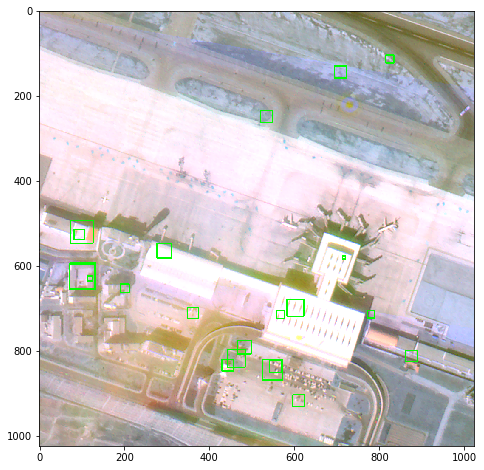

In [115]:
def classify_proposals(rects, model, img, plot=False):
    """
    Inputs:
    - rects: output from reduce_proposals, a numpy array. rects[i] gives the information for the i-th proposal
    including x, y, w, h (x and y is the coordinate of the top left corner, w and
    h is the width and height of the box). 
    - model:
    - img: the original image array 
    Outputs:
    - label_1_boxes: numpy array of shape (a,4) where a is the number of proposals classified as static
    planse. label_1_boxes[i] gives 4 coordinates x,y,z,t where (x,y) is the coordinate of the top left 
    vertex and (z,t) is the coordinate of the bottom right vertex.
    - label_2_boxes: similar to label_1_boxes, but for proposals classified as moving planes.
    """
    all_boxes = []
    X_test = [] # array of all proposals, to be fed into cnn for predictions
    for i, rect in enumerate(rects):
        x,y,w,h = rect
        all_boxes.append([x, y, x+w, y+w])
        box = img[y:y+h, x:x+w, :]
        # resize box to 224x224
        try:
            resized = imresize(box, (224, 224,3))       
        except:
            print(i,rect)
        X_test.append(resized)
    all_boxes = np.array(all_boxes)
    X_test = np.array(X_test)
    
    # predict
    scores = model.predict(X_test, verbose=1)
    preds = np.argmax(scores, axis=1)
    label_1_boxes = all_boxes[np.where(preds==1)]
    label_2_boxes = all_boxes[np.where(preds==2)]
    
    if plot:
        print("Detected planes:")
        for box in label_1_boxes:
            color = (255,0,0)
            p = box
            cv2.rectangle(img, (p[0],p[1]), (p[2],p[3]), color, 2)
        for box in label_1_boxes:
            color = (0,255,0)
            p = box
            cv2.rectangle(img, (p[0],p[1]), (p[2],p[3]), color, 2)
        plt.figure(figsize=(8,8))
        plt.imshow(img)
        plt.show()
    return label_1_boxes, label_2_boxes

# demo
model = load_model('model.h5', custom_objects={'loss':loss})
# classify the first 50 boxes
label_1_boxes, label_2_boxes = classify_proposals(rects[:50], 
                                                  model=model, img=img,
                                                 plot=True)


# Putting everything together

In [116]:
model = load_model('model.h5', custom_objects={'loss':loss})

def detect_img(model, img_file):
    img = cv2.imread('../airport_crop/' + img_file)
    # filtering the image
    print('Filtering image...\n')
    mask = get_mask(img, plot=False)
    print('='*20)
    
    # get proposals 
    print('Getting region proposals...\n')
    rects = get_proposals(img, selective_search_method='q', verbose=True, plot=True)
    print('='*20)

    # reduce the number of proposals
    print('Reducing the number of proposals...\n')
    rects = reduce_proposals(rects, mask, verbose=True)
    print('='*20)
    
    # classify all proposals
    print('Classifying the proposals...\n')
    label_1_boxes, label_2_boxes = classify_proposals(rects, model, img, plot=True)
    print('='*20)
    
    # calculate metric (INCOMPLETE)
    ## do something with label_1_boxes, label_2_boxes


Filtering image...

Getting region proposals...

Total Number of Region Proposals: 18039
Plotting the first 200 region proposals with mode q


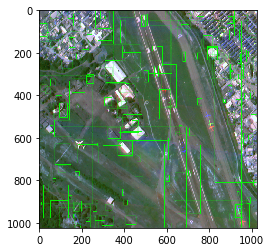

Reducing the number of proposals...

Reduce from 18039 to 10095
Classifying the proposals...



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


10095/10095 [==============================] - 3303s 327ms/step
Detected planes:


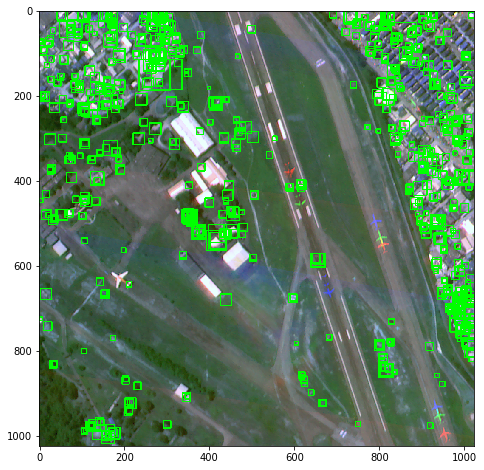

In [117]:
## Detecting planes in '39.png'
detect_img(model=model, img_file='39.png')